In [1]:
# https://colab.research.google.com/drive/1tTiOgJ7xvy3sjfiFC9OozbjAX1ho8WN9?usp=sharing

In [2]:
import os
import zipfile
import shutil
import urllib.request
import logging
import lzma
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, TFBertForMaskedLM, TFBertForQuestionAnswering

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Functions

In [3]:

def get_pretrained_squad_model(model_name):
    
    model, tokenizer = None, None
    
    if model_name == "distilbertsquad1":        
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad",use_fast=True)
        model = TFBertForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad", from_pt=True)
    
    elif model_name == "distilbertsquad2": 
        tokenizer = AutoTokenizer.from_pretrained("twmkn9/distilbert-base-uncased-squad2",use_fast=True)
        model = TFAutoModelForQuestionAnswering.from_pretrained("twmkn9/distilbert-base-uncased-squad2", from_pt=True)
    
    elif model_name == "bertsquad2": 
        tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2",use_fast=True)
        model = TFBertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2", from_pt=True)
    
    elif model_name == "bertlargesquad2": 
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",use_fast=True)
        model = TFBertForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2", from_pt=True)
    
    elif model_name == "albertbasesquad2": 
        tokenizer = AutoTokenizer.from_pretrained("twmkn9/albert-base-v2-squad2",use_fast=True)
        model = TFBertForQuestionAnswering.from_pretrained("twmkn9/albert-base-v2-squad2", from_pt=True)
    
    elif model_name == "distilrobertasquad2": 
        tokenizer = AutoTokenizer.from_pretrained("twmkn9/distilroberta-base-squad2",use_fast=True)
        model = TFBertForQuestionAnswering.from_pretrained("twmkn9/distilroberta-base-squad2", from_pt=True)
    
    elif model_name == "robertasquad2": 
        tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2",use_fast=True)
        model = TFAutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2", from_pt=True)
    
    elif model_name == "bertlm":
        
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",use_fast=True)
        model = TFBertForMaskedLM.from_pretrained("bert-base-uncased", from_pt=True)

    return model, tokenizer

In [4]:
def get_answer_span(question, context, model, tokenizer): 
    inputs = tokenizer.encode_plus(question, context, return_tensors="tf", add_special_tokens=True, max_length=512) 
    answer_start_scores, answer_end_scores = model(inputs)  
    answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0] 
    answer_end = (tf.argmax(answer_end_scores, axis=1) + 1).numpy()[0]  
    print(tokenizer.convert_tokens_to_string(inputs["input_ids"][0][answer_start:answer_end]))

    return answer_start, answer_end

In [5]:

def clean_tokens(gradients, tokens, token_types):
  
    """
      Clean the tokens and gradients gradients
      Remove "[CLS]","[CLR]", "[SEP]" tokens
      Reduce (mean) gradients values for tokens that are split ##
    """
    
    token_holder = []
    token_type_holder = []    
    gradient_holder = []     
    i = 0
    
    while i < len(tokens):
        if (tokens[i] not in ["[CLS]","[CLR]", "[SEP]"]):
            token = tokens[i]              
            conn = gradients[i]               
            token_type = token_types[i]
            
            if i < len(tokens)-1 :
                if tokens[i+1][0:2] == "##":
                    token = tokens[i]
                    conn = gradients[i]  
                    j = 1
                    while i < len(tokens)-1 and tokens[i+1][0:2] == "##":                        
                        i +=1 
                        token += tokens[i][2:]
                        conn += gradients[i]   
                        j+=1
                    conn = conn /j 
            token_holder.append(token)
            token_type_holder.append(token_type)
            gradient_holder.append(conn)
    
        i +=1
  
    return  gradient_holder,token_holder, token_type_holder

def get_best_start_end_position(start_scores, end_scores):
    
    answer_start = tf.argmax(start_scores, axis=1).numpy()[0] 
    answer_end = (tf.argmax(end_scores, axis=1) + 1).numpy()[0] 
    return answer_start, answer_end

def get_correct_span_mask(correct_index, token_size):
    
    span_mask = np.zeros((1, token_size))
    span_mask[0, correct_index] = 1
    span_mask = tf.constant(span_mask, dtype='float32')
    
    return span_mask 
 
def get_embedding_matrix(model):
    
    if "DistilBert" in type(model).__name__:
        return model.distilbert.embeddings.word_embeddings
    else:
        return model.bert.embeddings.word_embeddings

def get_gradient(question, context, model, tokenizer): 
    
    """Return gradient of input (question) wrt to model output span prediction 

      Args:
          question (str): text of input question
          context (str): text of question context/passage
          model (QA model): Hugging Face BERT model for QA transformers.modeling_tf_distilbert.TFDistilBertForQuestionAnswering, transformers.modeling_tf_bert.TFBertForQuestionAnswering
          tokenizer (tokenizer): transformers.tokenization_bert.BertTokenizerFast 

      Returns:
            (tuple): (gradients, token_words, token_types, answer_text)
    """
    embedding_matrix = get_embedding_matrix(model)  
    encoded_tokens =  tokenizer.encode_plus(question, context, add_special_tokens=True, return_token_type_ids=True, return_tensors="tf")
    token_ids = list(encoded_tokens["input_ids"].numpy()[0])
    vocab_size = embedding_matrix.get_shape()[0]

    # convert token ids to one hot. We can't differentiate wrt to int token ids hence the need for one hot representation

    token_ids_tensor = tf.constant([token_ids], dtype='int32')
    token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size) 
  
 
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        
        # (i) watch input variable
        tape.watch(token_ids_tensor_one_hot)
 
        # multiply input model embedding matrix; allows us do backprop wrt one hot input 
        inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)  

        # (ii) get prediction
        start_scores,end_scores = model({"inputs_embeds": inputs_embeds, "token_type_ids": encoded_tokens["token_type_ids"], "attention_mask": encoded_tokens["attention_mask"] })
        answer_start, answer_end = get_best_start_end_position(start_scores, end_scores)

        start_output_mask = get_correct_span_mask(answer_start, len(token_ids))
        end_output_mask = get_correct_span_mask(answer_end, len(token_ids))

        # zero out all predictions outside of the correct span positions; we want to get gradients wrt to just these positions
        predict_correct_start_token = tf.reduce_sum(start_scores * start_output_mask)
        predict_correct_end_token = tf.reduce_sum(end_scores * end_output_mask) 

        # (iii) get gradient of input with respect to both start and end output
        gradient_non_normalized = tf.norm(
            tape.gradient([predict_correct_start_token, predict_correct_end_token], token_ids_tensor_one_hot),axis=2)

        # (iv) normalize gradient scores and return them as "explanations"
        gradient_tensor = (
            gradient_non_normalized /
            tf.reduce_max(gradient_non_normalized)
        )
        gradients = gradient_tensor[0].numpy().tolist()

        token_words = tokenizer.convert_ids_to_tokens(token_ids) 
        token_types = list(encoded_tokens["token_type_ids"].numpy()[0])
        answer_text = tokenizer.decode(token_ids[answer_start:answer_end])

        return  gradients,  token_words, token_types,answer_text


def explain_model(question, context, model, tokenizer, explain_method = "gradient"):    
    if explain_method == "gradient":        
        return get_gradient(question, context, model, tokenizer)


In [6]:
def plot_gradients(tokens, token_types, gradients, title): 
    
    """ Plot  explanations
    """
    plt.figure(figsize=(21,3)) 
    xvals = [ x + str(i) for i,x in enumerate(tokens)]
    colors =  [ (0,0,1, c) for c,t in zip(gradients, token_types) ]
    edgecolors = [ "black" if t==0 else (0,0,1, c)  for c,t in zip(gradients, token_types) ]
    # colors =  [  ("r" if t==0 else "b")  for c,t in zip(gradients, token_types) ]    
    plt.tick_params(axis='both', which='minor', labelsize=29)    
    p = plt.bar(xvals, gradients, color=colors, linewidth=1, edgecolor=edgecolors)    
    plt.title(title)     
    p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90) 

## Lets Test on 8 Random Question/Context pairs.

In [7]:
questions = [
    { "question": "what is the goal of the fourth amendment?  ", "context": "The Fourth Amendment of the U.S. Constitution provides that '[t]he right of the people to be secure in their persons, houses, papers, and effects, against unreasonable searches and seizures, shall not be violated, and no Warrants shall issue, but upon probable cause, supported by Oath or affirmation, and particularly describing the place to be searched, and the persons or things to be seized.'The ultimate goal of this provision is to protect people’s right to privacy and freedom from unreasonable intrusions by the government. However, the Fourth Amendment does not guarantee protection from all searches and seizures, but only those done by the government and deemed unreasonable under the law." },
    { "question": "what is the taj mahal made of?", "context": "The Taj Mahal is an ivory-white marble mausoleum on the southern bank of the river Yamuna in the Indian city of Agra. It was commissioned in 1632 by the Mughal emperor Shah Jahan (reigned from 1628 to 1658) to house the tomb of his favourite wife, Mumtaz Mahal; it also houses the tomb of Shah Jahan himself. The tomb is the centrepiece of a 17-hectare (42-acre) complex, which includes a mosque and a guest house, and is set in formal gardens bounded on three sides by a crenellated wall. Construction of the mausoleum was essentially completed in 1643, but work continued on other phases of the project for another 10 years. The Taj Mahal complex is believed to have been completed in its entirety in 1653 at a cost estimated at the time to be around 32 million rupees, which in 2020 would be approximately 70 billion rupees (about U.S. $916 million). The construction project employed some 20,000 artisans under the guidance of a board of architects led by the court architect to the emperor. The Taj Mahal was designated as a UNESCO World Heritage Site in 1983 for being the jewel of Muslim art in India and one of the universally admired masterpieces of the world's heritage. It is regarded by many as the best example of Mughal architecture and a symbol of India's rich history. The Taj Mahal attracts 7–8 million visitors a year and in 2007, it was declared a winner of the New 7 Wonders of the World (2000–2007) initiative." },
    { "question": "Who ruled macedonia ", "context": "Macedonia was an ancient kingdom on the periphery of Archaic and Classical Greece, and later the dominant state of Hellenistic Greece. The kingdom was founded and initially ruled by the Argead dynasty, followed by the Antipatrid and Antigonid dynasties. Home to the ancient Macedonians, it originated on the northeastern part of the Greek peninsula. Before the 4th century BC, it was a small kingdom outside of the area dominated by the city-states of Athens, Sparta and Thebes, and briefly subordinate to Achaemenid Persia" },
    { "question": "what are the symptoms of COVID-19", "context": "COVID-19 is the infectious disease caused by the most recently discovered coronavirus. This new virus and disease were unknown before the outbreak began in Wuhan, China, in December 2019. The most common symptoms of COVID-19 are fever, tiredness, and dry cough. Some patients may have aches and pains, nasal congestion, runny nose, sore throat or diarrhea. These symptoms are usually mild and begin gradually. Some people become infected but don’t develop any symptoms and don't feel unwell. Most people (about 80%) recover from the disease without needing special treatment. Around 1 out of every 6 people who gets COVID-19 becomes seriously ill and develops difficulty breathing. Older people, and those with underlying medical problems like high blood pressure, heart problems or diabetes, are more likely to develop serious illness. People with fever, cough and difficulty breathing should seek medical attention." },
]


In [8]:

# bqa_model, bqa_tokenizer = get_pretrained_squad_model('distilbertsquad1')

# token_subset = 90
# for row in questions:
#     question, context = row["question"], row["context"]
  
#     gradients, tokens, token_types, answer  = explain_model(question, context, bqa_model, bqa_tokenizer)
#     gradients, tokens, token_types = clean_tokens(gradients, tokens, token_types) 
#     plot_gradients(tokens, token_types, gradients, "Q: " +question + " | A: "+ answer)
#     plot_gradients(tokens[:token_subset], token_types[:token_subset], gradients[:token_subset], "Q: " +question + " | A: " + answer)



In [9]:

model_names = ["distilbertsquad1","distilbertsquad2","bertsquad2","bertlargesquad2"]
result_holder = []
for model_name in model_names:
    bqa_model, bqa_tokenizer = get_pretrained_squad_model(model_name)
    
    for row in questions:
        
        start_time = time.time() 
        question, context = row["question"], row["context"] 
        gradients, tokens, token_types, answer  = explain_model(question, context, bqa_model, bqa_tokenizer) 
        elapsed_time = time.time() - start_time
        result_holder.append({"question": question,  "context":context, "answer": answer, "model": model_name, "runtime": elapsed_time})

result_df = pd.DataFrame(result_holder)

,question,answer_distilbertsquad1,answer_distilbertsquad2,answer_bertsquad2,answer_bertlargesquad2
0,what is the goal of the fourth amendment?,? [SEP] The Fourth Amendment of the U. S. Cons...,to protect people ’ s right to privacy and fre...,protect people ’ s right to privacy and freedo...,to protect people ’ s right to privacy and fre...
1,what is the taj mahal made of?,to,ivory - white marble,ivory - white marble,ivory - white marble
2,Who ruled macedonia,to,argead dynasty,the Argead dynasty,the kingdom was founded and initially ruled by...
3,what are the symptoms of COVID-19,##rhea. These symptoms are usually mild and be...,"fever, tiredness, and dry cough","fever, tiredness, and dry cough","fever, tiredness, and dry cough"


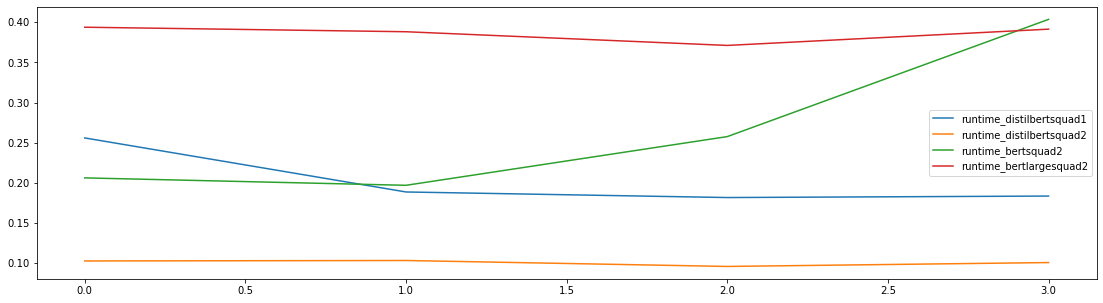

In [10]:
question_df = result_df[result_df["model"] == "bertsquad2"].reset_index()[["question"]]
df_list = [question_df]
for model_name in model_names:
    
    sub_df = result_df[result_df["model"] == model_name].reset_index()[["answer", "runtime"]]
    sub_df.columns = [ (col_name + "_" + model_name)  for col_name in sub_df.columns]
    df_list.append(sub_df)
    
jdf = pd.concat(df_list, axis=1)
answer_cols = ["question"] + [col for col in jdf.columns if 'answer' in col] 
jdf.plot(kind="line", figsize=(19,5))
jdf[answer_cols]

In [11]:
runtime_cols = [col for col in jdf.columns if 'runtime' in col] 
mean_runtime = jdf[runtime_cols].mean()
print("Mean runtime per model across 4 question/context pairs")
print(mean_runtime)

Mean runtime per model across 4 question/context pairs
runtime_distilbertsquad1    0.202405
runtime_distilbertsquad2    0.100577
runtime_bertsquad2          0.266057
runtime_bertlargesquad2     0.386156
dtype: float64


# TODO

### Reflections on Performance
- Distilbert SQUAD1 (261M): returns 5/8. 2 correct answers.
- Distilbert SQUAD2 (265MB): returns 7/8 answers. 7 correct answers
- BERT base (433MB): returns 5/8 answers. 5 correct answers
- BERT large (1.34GB): returns 7/8 answers. 7 correct answers



Explanations like the gradient method above and model output provide a few insights on BERT based QA models. 

- We see that in cases where BERT does not have an answer (e.g. it outputs a CLS token only), it generally does not have high normalized gradient scores for most of the input tokens. Perhaps explanation scores can be combined with model confidence scores (start/end span softmax) to build a more complete metric for confidence in the span prediction.
- There are some cases where the model appears to be responsive to the right tokens but still fails to return an answer. Having a larger model (e.g bert large) helps in some cases (see output above). Bert base correctly finds answers for 5/8 questions while BERT large finds answers for 7/8 questions.
There is a cost though .. bert base model size is 433MB vs bertlarge ~1.34GB and almost 3x the run time. 
- On the rather randomly selected question/context pairs above, the smaller, faster DistilBERT (squad2) suprisingly performs better than BERTbase and at par with BERTlarge. Results also demonstrate why, we all should not be using QA models trained on SQUAD1. 

In addition to these insights, explanations also enable sensemaking of model results by end users. In this case, sensemaking from the Human Computer Interaction perspective is focused on interface affordances that help the user build intuition on how, why and when these models work.